# <center><font color = "green">PUBG Game Prediction</font></center>

<center><img src = "https://pngimg.com/uploads/pubg/small/pubg_PNG40.png"></img></center>

### Table Contents
1. [Importing Libraries](#import)
2. [Reading the Data](#read)
3. [Data Wrangling](#wrangle)
4. [Feature Engineering](#feature)
5. [ML - Catboost Model](#catboost) 

# <font color = "green">Importing the Libraries</font><a class = "anchor" id = "import"></a>

In [42]:
# standard libraries
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 8)

import seaborn as sns

# handling warnings
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import catboost as cb

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# <font color = "green">Reading the Data</font><a class = "anchor" id = "read"></a>

In [43]:
# loading the data
df = pd.read_csv("PUBG_Game_Prediction_data.csv")

In [44]:
# glimpse of the data
df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [45]:
# data dimesion
df.shape

(4446966, 29)

In [46]:
# data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

### Data Descritption
* DBNOs - Number of enemy players knocked.
* assists - Number of enemy players this player damaged that were killed by teammates.
* boosts - Number of boost items used.
* damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.
* headshotKills - Number of enemy players killed with headshots.
* heals - Number of healing items used.
* Id - Player’s Id
* killPlace - Ranking in match of number of enemy players killed.
* killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.
* killStreaks - Max number of enemy players killed in a short amount of time.
* kills - Number of enemy players killed.
* longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.
* matchDuration - Duration of match in seconds.
* matchId - ID to identify match. There are no matches that are in both the training and testing set.
* matchType - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.
* rankPoints - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.
* revives - Number of times this player revived teammates.
* rideDistance - Total distance traveled in vehicles measured in meters.
* roadKills - Number of kills while in a vehicle.
* swimDistance - Total distance traveled by swimming measured in meters.
* teamKills - Number of times this player killed a teammate.
* vehicleDestroys - Number of vehicles destroyed.
* walkDistance - Total distance traveled on foot measured in meters.-
* weaponsAcquired - Number of weapons picked up.
* winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.
* groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
* numGroups - Number of groups we have data for in the match.
* maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
* winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

# <font color = "green">Data Wrangling</font><a class = "anchor" id = "wrangle"></a>

Check for rows will null win prediction

In [47]:
# finding the indexes with null win prediction values
df[df['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [48]:
# drop the null values
df.drop(2744604, inplace = True)

Understanding the players distribution in a game

In [49]:
# new parameter to know how many players are in a match
df['joinedPlayers'] = df.groupby('matchId')['matchId'].transform('count')

In [50]:
df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,joinedPlayers
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0.0000,0,0.00,0,0,244.80,1,1466,0.4444,96
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0.0045,0,11.04,0,0,1434.00,5,0,0.6400,91
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0.0000,0,0.00,0,0,161.80,2,0,0.7755,98
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0.0000,0,0.00,0,0,202.70,3,0,0.1667,91
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0.0000,0,0.00,0,0,49.75,2,0,0.1875,97


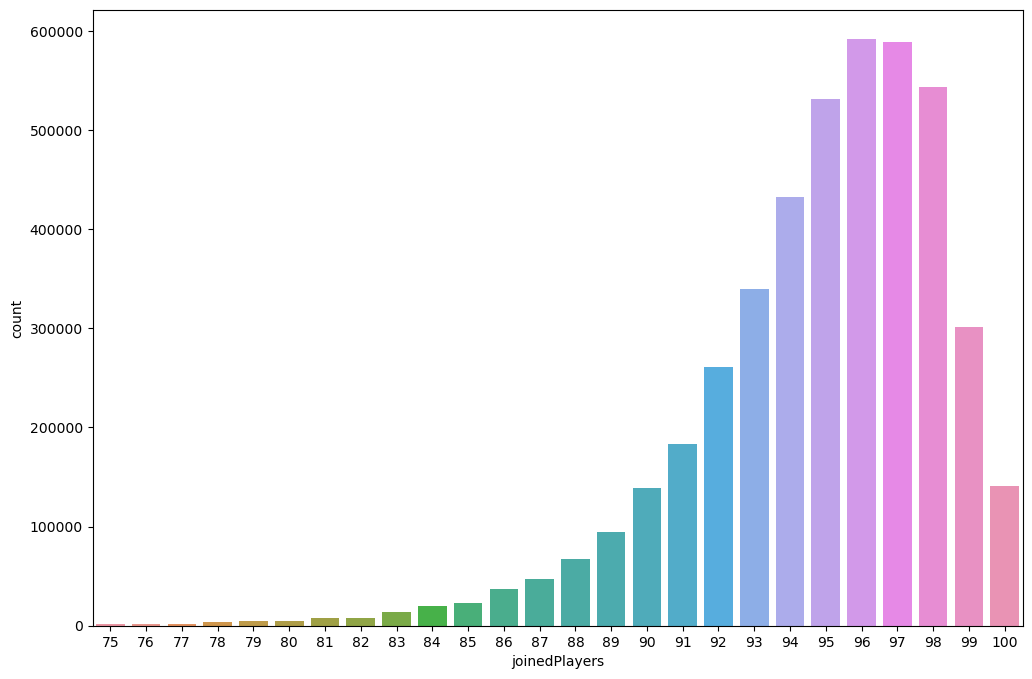

In [51]:
sns.countplot(df, x = df[df['joinedPlayers']>=75]['joinedPlayers'])
#sns.countplot(df[df['playersJoined']>=75]['playersJoined'])
plt.show()

## Analysing the Data

Kills without moving?

In [52]:
# new parameter to calculate the total distance travelled
df['totalDistance'] = df['rideDistance'] + df['walkDistance'] + df['swimDistance']

# new parameter to find player who killed without moving a bit
df['killedWithoutMoving'] = ((df['kills'] > 0) & (df['totalDistance'] == 0))

In [53]:
df[df['killedWithoutMoving'] == True].head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,joinedPlayers,totalDistance,killedWithoutMoving
1824,b538d514ef2476,0eb2ce2f43f9d6,35e7d750e442e2,0,0,593.0,0,0,3,18,...,0.0,0,0,0.0,8,0,0.8571,58,0.0,True
6673,6d3a61da07b7cb,2d8119b1544f87,904cecf36217df,2,0,346.6,0,0,6,33,...,0.0,0,0,0.0,22,0,0.6000,42,0.0,True
11892,550398a8f33db7,c3fd0e2abab0af,db6f6d1f0d4904,2,0,1750.0,0,4,5,3,...,0.0,0,0,0.0,13,0,0.8947,21,0.0,True
14631,58d690ee461e9d,ea5b6630b33d67,dbf34301df5e53,0,0,157.8,0,0,0,69,...,0.0,0,0,0.0,7,1500,0.0000,73,0.0,True
15591,49b61fc963d632,0f5c5f19d9cc21,904cecf36217df,0,0,100.0,0,1,0,37,...,0.0,0,0,0.0,10,0,0.3000,42,0.0,True


In [54]:
df[df['killedWithoutMoving'] == True].shape

(1535, 32)

In [55]:
df[df['killedWithoutMoving'] == True].index

Int64Index([   1824,    6673,   11892,   14631,   15591,   20881,   23298,
              24640,   25659,   30079,
            ...
            4426500, 4429697, 4432954, 4436511, 4437516, 4440232, 4440898,
            4440927, 4441511, 4446682],
           dtype='int64', length=1535)

In [56]:
# droping the data
df.drop(df[df['killedWithoutMoving'] == True].index, inplace = True)

Extra Ordinary Road Kills

In [57]:
df[df['roadKills']>5].shape

(46, 32)

In [58]:
# drop the instances
df.drop(df[df['roadKills']>5].index, inplace = True)

So many kills, how ??

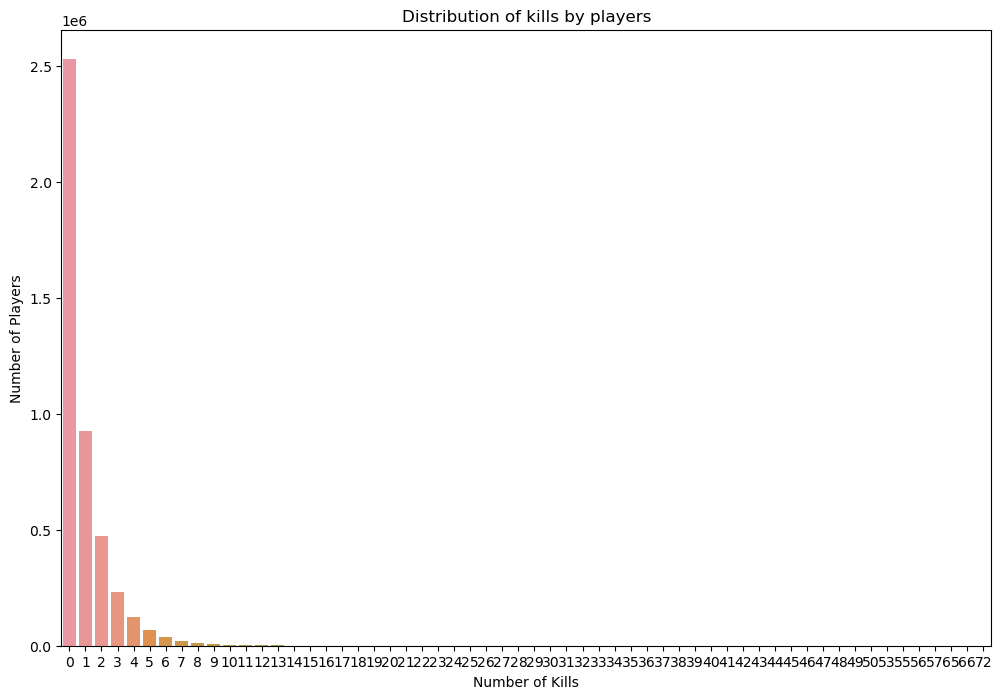

In [59]:
sns.countplot(df, x = df['kills'])
plt.title('Distribution of kills by players')
plt.xlabel('Number of Kills')
plt.ylabel('Number of Players')
plt.show()

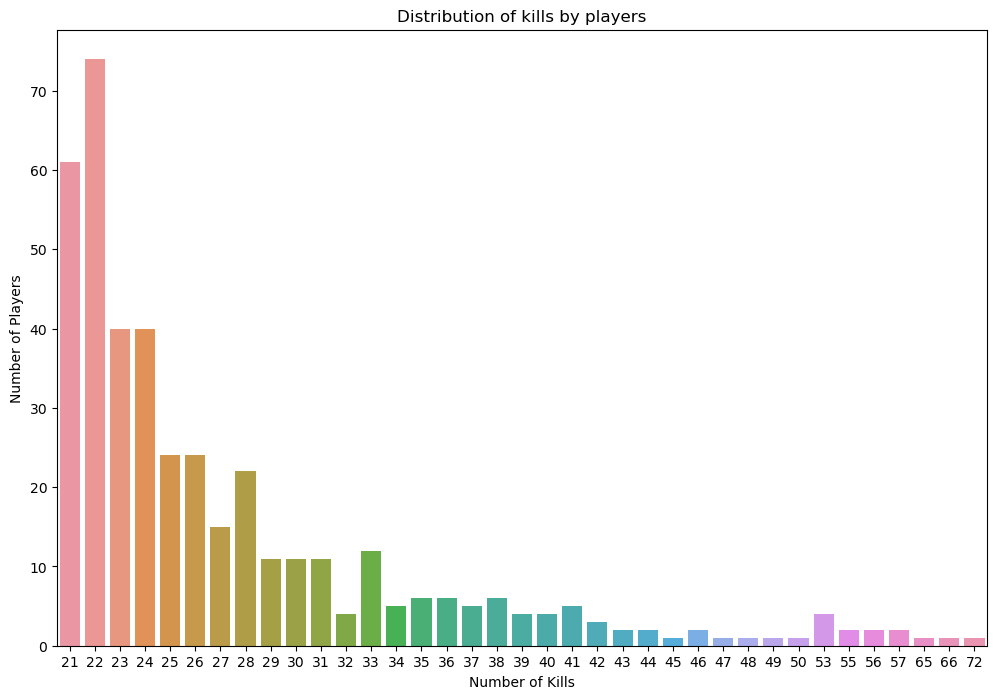

In [60]:
sns.countplot(df, x = df[df['kills'] > 20]['kills'])
plt.title('Distribution of kills by players')
plt.xlabel('Number of Kills')
plt.ylabel('Number of Players')
plt.show()

In [61]:
# data dimesion
df[df['kills'] > 20].shape

(417, 32)

In [62]:
# droping the instances
df.drop(df[df['kills'] > 20].index, inplace = True)

Number of Headshots

In [63]:
# new parameter to check the headshot rate
df['headshotRate'] = df['headshotKills']/df['kills']
df['headshotRate'] = df['headshotRate'].fillna(0)

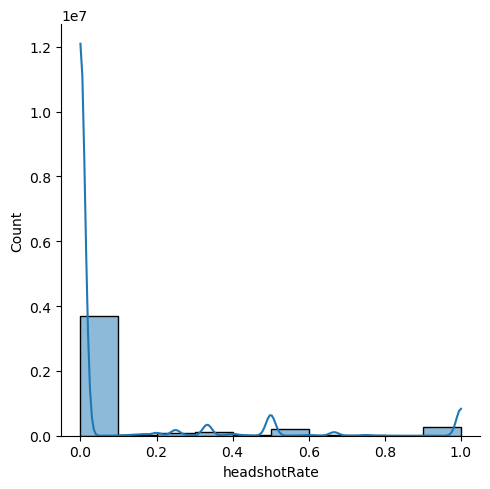

In [64]:
sns.displot(df, x = df['headshotRate'], bins = 10, kde = True)
plt.show()

In [65]:
df[(df['headshotRate'] == 1) & (df['kills'] > 5)].shape

(187, 33)

In [66]:
df.drop(df[(df['headshotRate'] == 1) & (df['kills'] > 5)].index, inplace = True)

Longest Shot

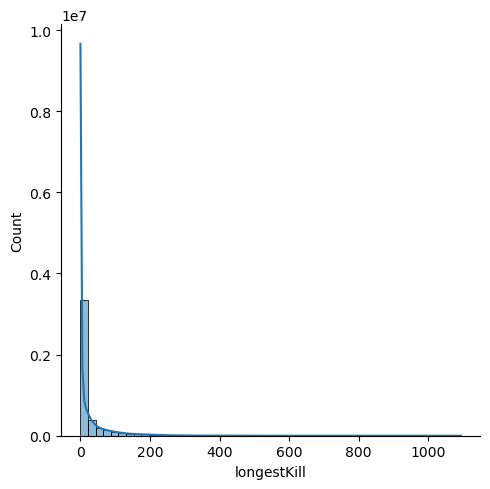

In [67]:
sns.displot(df, x = df['longestKill'], bins = 50, kde = True)
plt.show()

In [68]:
df[df['longestKill'] >= 500].shape

(1738, 33)

In [69]:
df.drop(df[df['longestKill'] >= 500].index, inplace = True)

Weapon change

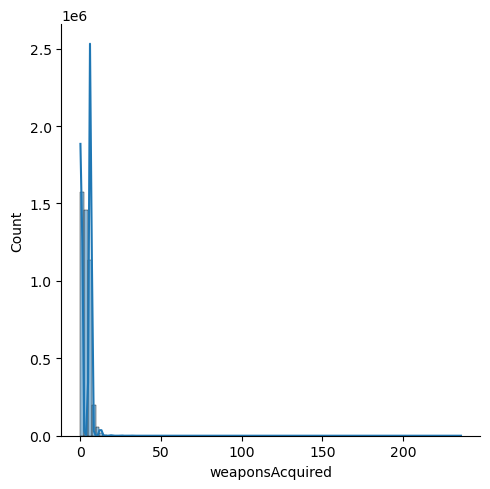

In [70]:
sns.displot(df, x = df['weaponsAcquired'], bins = 100, kde = True)
plt.show()

In [71]:
df[df['weaponsAcquired'] > 15].shape

(5435, 33)

In [72]:
df.drop(df[df['weaponsAcquired'] > 15].index, inplace = True)

EDA

In [73]:
df.shape

(4437607, 33)

In [74]:
df.isna().sum()

Id                     0
groupId                0
matchId                0
assists                0
boosts                 0
damageDealt            0
DBNOs                  0
headshotKills          0
heals                  0
killPlace              0
killPoints             0
kills                  0
killStreaks            0
longestKill            0
matchDuration          0
matchType              0
maxPlace               0
numGroups              0
rankPoints             0
revives                0
rideDistance           0
roadKills              0
swimDistance           0
teamKills              0
vehicleDestroys        0
walkDistance           0
weaponsAcquired        0
winPoints              0
winPlacePerc           0
joinedPlayers          0
totalDistance          0
killedWithoutMoving    0
headshotRate           0
dtype: int64

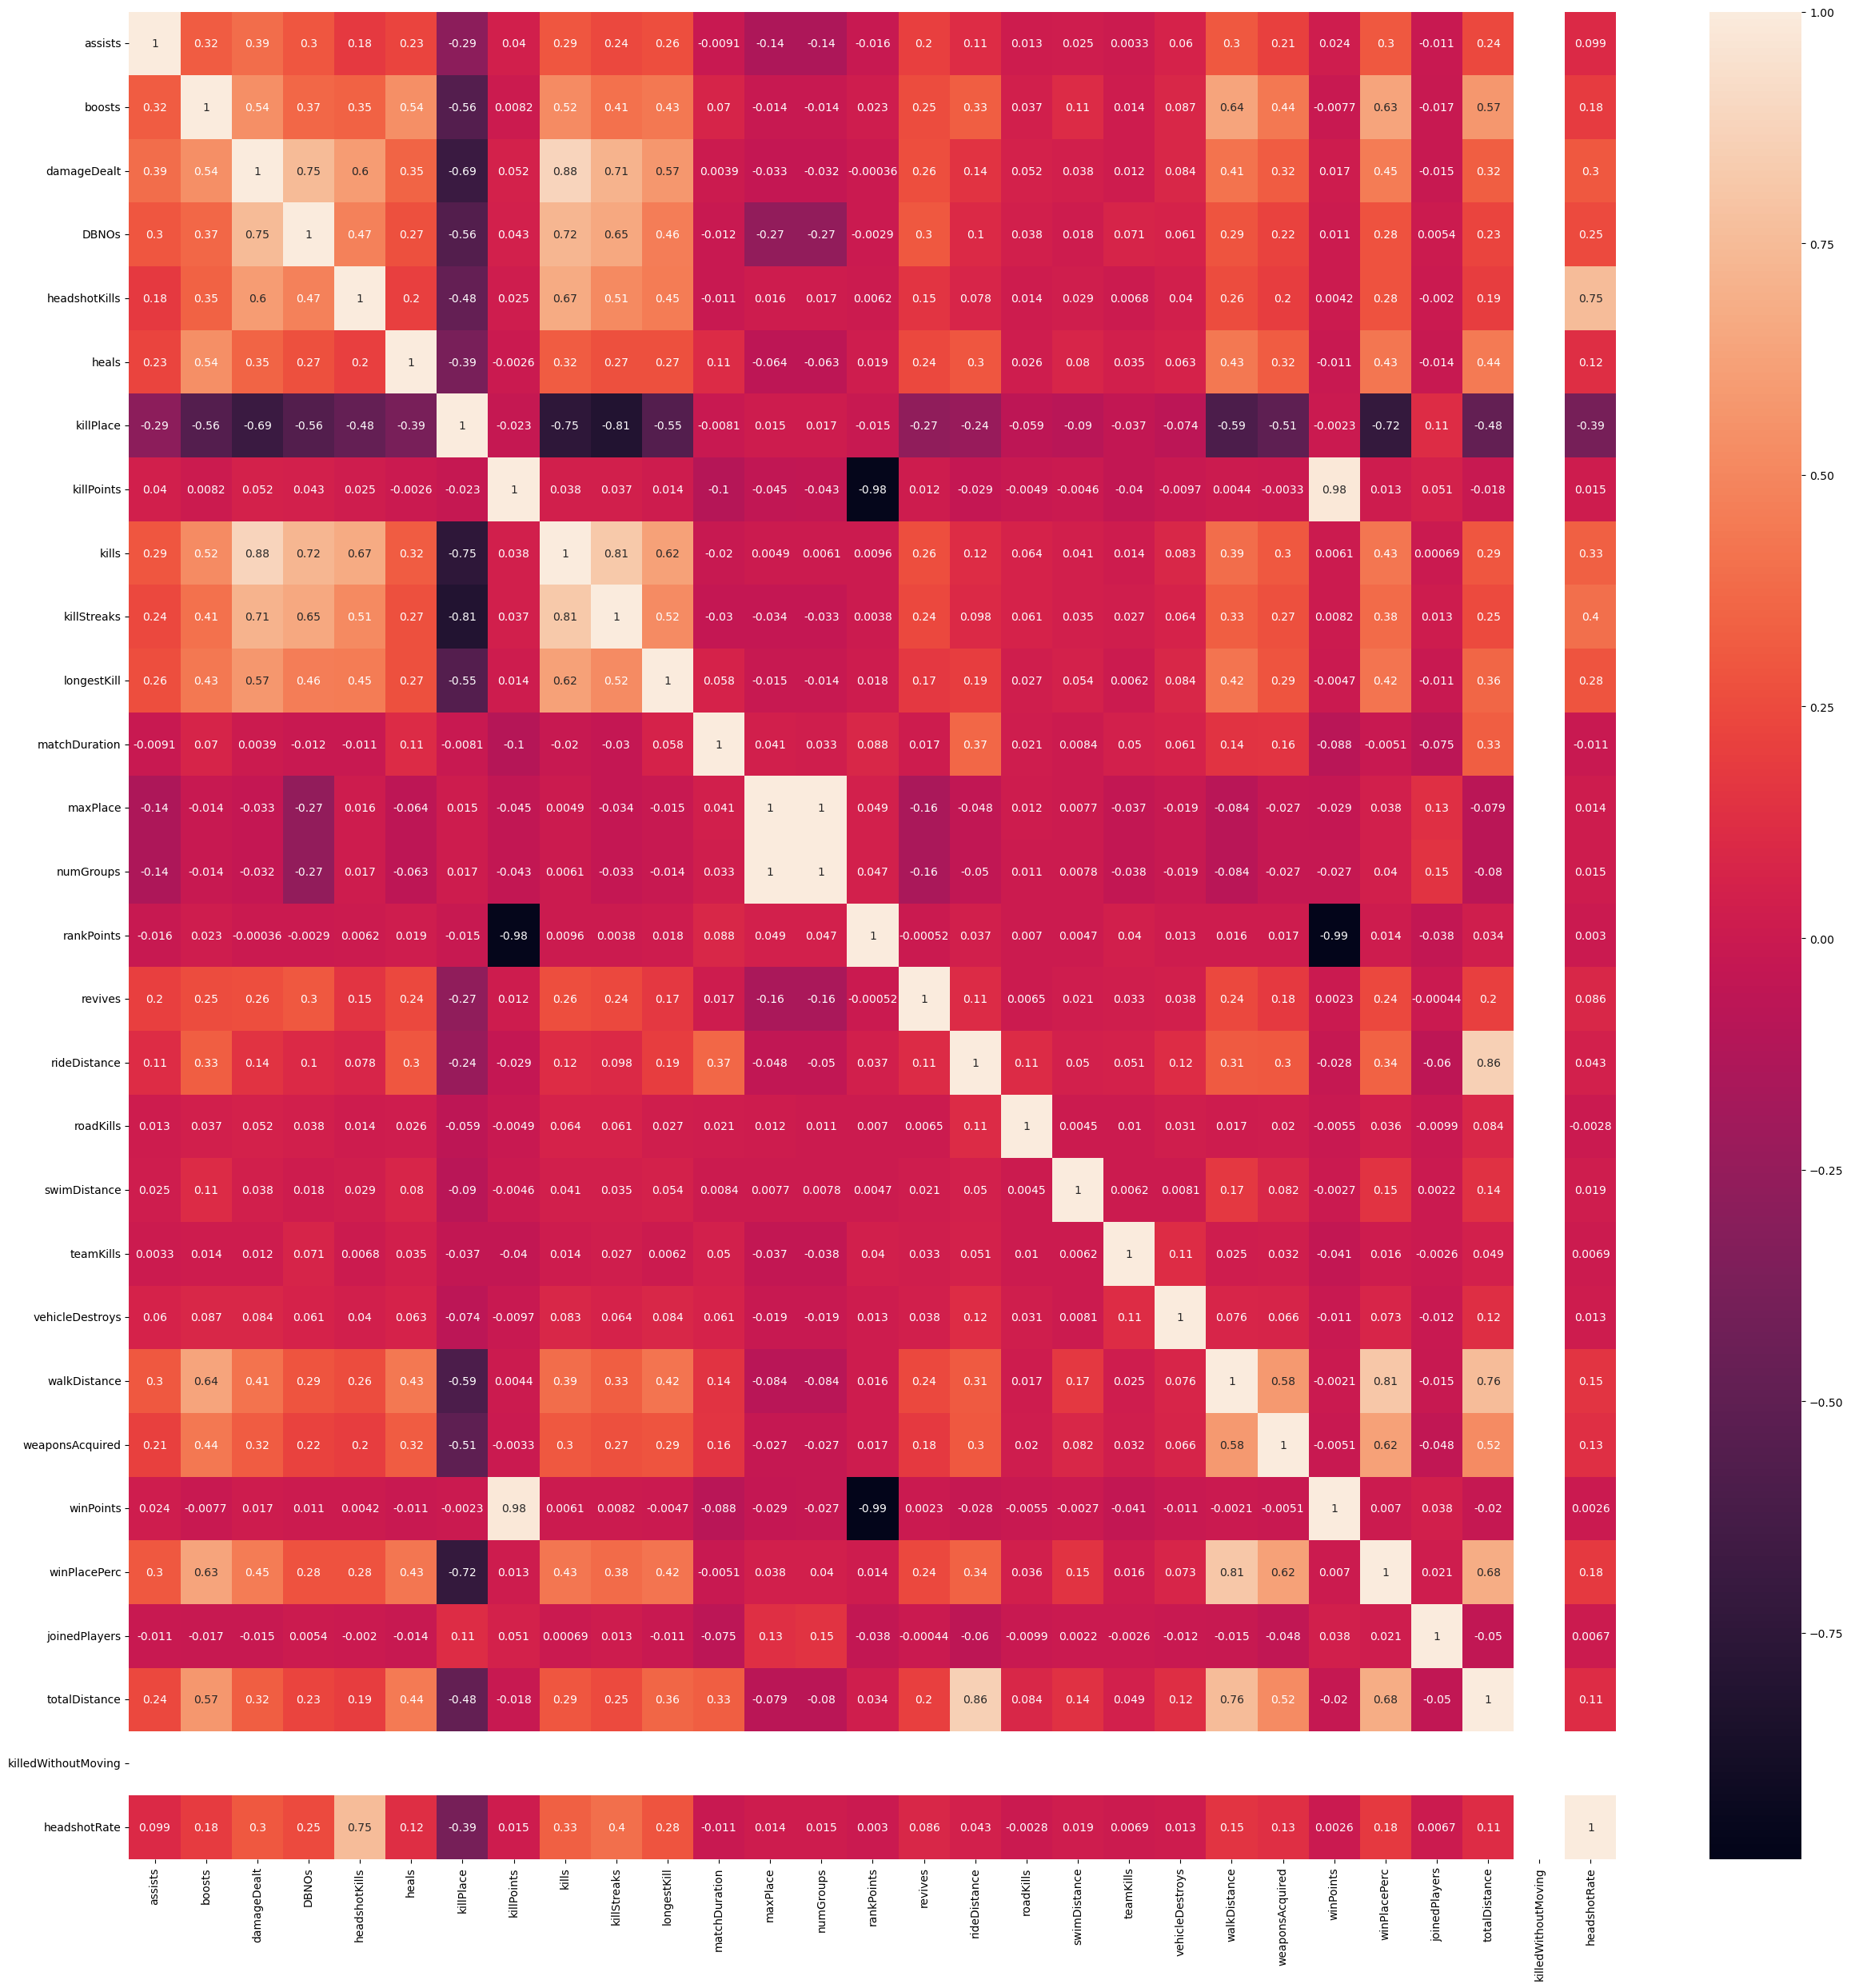

In [75]:
# correlation of parameters with Win Prediction
plt.figure(figsize = (30, 30))
sns.heatmap(df.corr(), annot = True)
plt.show()

# <font color = "green">Feature Engineering</font><a class = "anchor" id = "feature"></a>

In [76]:
normalising_factor = (100 - df['joinedPlayers']/100) + 1

In [77]:
df['killsNorm'] = df['kills'] * normalising_factor
df['damageDealtNorm'] = df['damageDealt'] * normalising_factor
df['maxPlaceNorm'] = df['maxPlace'] * normalising_factor
df['matchDurationNorm'] = df['matchDuration'] * normalising_factor

df['travelDistance'] = df['walkDistance'] + df['rideDistance'] + df['swimDistance']
df['healsnboosts'] = df['heals'] + df['boosts']
df['assist'] = df['assists'] + df['revives']

In [78]:
df.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc', 'joinedPlayers',
       'totalDistance', 'killedWithoutMoving', 'headshotRate', 'killsNorm',
       'damageDealtNorm', 'maxPlaceNorm', 'matchDurationNorm',
       'travelDistance', 'healsnboosts', 'assist'],
      dtype='object')

In [79]:
data = df.drop(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'heals', 'kills', 'matchDuration',
        'maxPlace', 'revives', 'rideDistance', 'swimDistance', 'walkDistance'], axis = 1)

In [80]:
data.head()

,DBNOs,headshotKills,killPlace,killPoints,killStreaks,longestKill,matchType,numGroups,rankPoints,roadKills,...,totalDistance,killedWithoutMoving,headshotRate,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,travelDistance,healsnboosts,assist
0,0,0,60,1241,0,0.00,squad-fpp,26,-1,0,...,244.8000,False,0.0,0.00,0.0000,2801.12,130652.24,244.8000,0,0
1,0,0,57,0,0,0.00,squad-fpp,25,1484,0,...,1445.0445,False,0.0,0.00,9155.2323,2602.34,177859.93,1445.0445,0,0
2,0,0,47,0,0,0.00,duo,47,1491,0,...,161.8000,False,0.0,0.00,6801.3600,5001.00,131826.36,161.8000,0,1
3,0,0,75,0,0,0.00,squad-fpp,30,1408,0,...,202.7000,False,0.0,0.00,3292.9610,3102.79,143729.24,202.7000,0,0
4,0,0,45,0,1,58.53,solo-fpp,95,1560,0,...,49.7500,False,0.0,100.03,10003.0000,9702.91,142442.72,49.7500,0,0


# <font color = "green">ML - Catboost Model</font><a class = "anchor" id = "catboost"></a>

Handling Categorical Data

In [102]:
x = data.drop(['winPlacePerc'], axis = 1)
y = data['winPlacePerc']

In [103]:
x = pd.get_dummies(x, columns = ['matchType', 'killedWithoutMoving'])

In [105]:
features = x.columns

In [106]:
x.head()

,DBNOs,headshotKills,killPlace,killPoints,killStreaks,longestKill,numGroups,rankPoints,roadKills,teamKills,...,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp,killedWithoutMoving_False
0,0,0,60,1241,0,0.00,26,-1,0,0,...,0,0,0,0,0,0,0,0,1,1
1,0,0,57,0,0,0.00,25,1484,0,0,...,0,0,0,0,0,0,0,0,1,1
2,0,0,47,0,0,0.00,47,1491,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,75,0,0,0.00,30,1408,0,0,...,0,0,0,0,0,0,0,0,1,1
4,0,0,45,0,1,58.53,95,1560,0,0,...,0,0,0,0,0,0,1,0,0,1


Scaling the Data

In [107]:
sc = StandardScaler()
sc.fit(x)
x = pd.DataFrame(sc.transform(x))

In [108]:
x.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-0.582723,-0.384144,0.449543,1.172543,-0.765176,-0.459690,-0.732763,-1.212394,-0.049576,-0.14253,...,-0.03364,-0.005516,-0.013898,-0.008426,-0.054799,-0.206547,-0.370782,-0.405072,1.236290,0.0
1,-0.582723,-0.384144,0.340251,-0.804724,-0.765176,-0.459690,-0.775734,0.803563,-0.049576,-0.14253,...,-0.03364,-0.005516,-0.013898,-0.008426,-0.054799,-0.206547,-0.370782,-0.405072,1.236290,0.0
2,-0.582723,-0.384144,-0.024055,-0.804724,-0.765176,-0.459690,0.169631,0.813066,-0.049576,-0.14253,...,-0.03364,-0.005516,-0.013898,-0.008426,-0.054799,-0.206547,-0.370782,-0.405072,-0.808872,0.0
3,-0.582723,-0.384144,0.996002,-0.804724,-0.765176,-0.459690,-0.560878,0.700389,-0.049576,-0.14253,...,-0.03364,-0.005516,-0.013898,-0.008426,-0.054799,-0.206547,-0.370782,-0.405072,1.236290,0.0
4,-0.582723,-0.384144,-0.096917,-0.804724,0.647529,0.727195,2.232245,0.906736,-0.049576,-0.14253,...,-0.03364,-0.005516,-0.013898,-0.008426,-0.054799,-0.206547,2.697000,-0.405072,-0.808872,0.0


Splitting the Data

In [93]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

In [95]:
print(x_train.shape)
x_test.shape

(3106324, 40)


(1331283, 40)

Catboost Model

In [98]:
train_dataset = cb.Pool(x_train, y_train)
test_dataset = cb.Pool(x_test, y_test)

In [100]:
model = cb.CatBoostRegressor(loss_function = 'RMSE')

In [101]:
# GRID Search

grid = {'iterations' : [100, 150],
        'learning_rate' : [0.03, 0.1],
        'depth' : [2, 4, 6, 8]}

model.grid_search(grid, train_dataset)

0:	learn: 0.5482519	test: 0.5480242	best: 0.5480242 (0)	total: 469ms	remaining: 46.5s
1:	learn: 0.5333848	test: 0.5331629	best: 0.5331629 (1)	total: 1.09s	remaining: 53.3s
2:	learn: 0.5190129	test: 0.5187977	best: 0.5187977 (2)	total: 1.58s	remaining: 51.2s
3:	learn: 0.5051012	test: 0.5048990	best: 0.5048990 (3)	total: 2.04s	remaining: 48.9s
4:	learn: 0.4916565	test: 0.4914660	best: 0.4914660 (4)	total: 2.35s	remaining: 44.7s
5:	learn: 0.4786285	test: 0.4784519	best: 0.4784519 (5)	total: 2.59s	remaining: 40.6s
6:	learn: 0.4660408	test: 0.4658692	best: 0.4658692 (6)	total: 2.82s	remaining: 37.4s
7:	learn: 0.4538440	test: 0.4536772	best: 0.4536772 (7)	total: 3.07s	remaining: 35.3s
8:	learn: 0.4420557	test: 0.4418957	best: 0.4418957 (8)	total: 3.29s	remaining: 33.3s
9:	learn: 0.4306235	test: 0.4304688	best: 0.4304688 (9)	total: 3.57s	remaining: 32.1s
10:	learn: 0.4196142	test: 0.4194635	best: 0.4194635 (10)	total: 3.84s	remaining: 31.1s
11:	learn: 0.4089338	test: 0.4087881	best: 0.4087881

94:	learn: 0.1399809	test: 0.1397399	best: 0.1397399 (94)	total: 25.4s	remaining: 1.34s
95:	learn: 0.1395790	test: 0.1393355	best: 0.1393355 (95)	total: 25.7s	remaining: 1.07s
96:	learn: 0.1392099	test: 0.1389631	best: 0.1389631 (96)	total: 26s	remaining: 805ms
97:	learn: 0.1388487	test: 0.1386012	best: 0.1386012 (97)	total: 26.4s	remaining: 538ms
98:	learn: 0.1384998	test: 0.1382510	best: 0.1382510 (98)	total: 26.7s	remaining: 270ms
99:	learn: 0.1381688	test: 0.1379193	best: 0.1379193 (99)	total: 27s	remaining: 0us

bestTest = 0.1379192679
bestIteration = 99

0:	loss: 0.1379193	best: 0.1379193 (0)	total: 31.6s	remaining: 7m 54s
0:	learn: 0.5126217	test: 0.5124066	best: 0.5124066 (0)	total: 239ms	remaining: 23.7s
1:	learn: 0.4671059	test: 0.4669072	best: 0.4669072 (1)	total: 509ms	remaining: 24.9s
2:	learn: 0.4264465	test: 0.4262882	best: 0.4262882 (2)	total: 777ms	remaining: 25.1s
3:	learn: 0.3903958	test: 0.3902710	best: 0.3902710 (3)	total: 1.01s	remaining: 24.2s
4:	learn: 0.3583335

87:	learn: 0.1174894	test: 0.1172520	best: 0.1172520 (87)	total: 19.8s	remaining: 2.69s
88:	learn: 0.1173801	test: 0.1171434	best: 0.1171434 (88)	total: 20s	remaining: 2.47s
89:	learn: 0.1172925	test: 0.1170623	best: 0.1170623 (89)	total: 20.2s	remaining: 2.24s
90:	learn: 0.1171981	test: 0.1169664	best: 0.1169664 (90)	total: 20.4s	remaining: 2.02s
91:	learn: 0.1171050	test: 0.1168729	best: 0.1168729 (91)	total: 20.6s	remaining: 1.79s
92:	learn: 0.1169552	test: 0.1167237	best: 0.1167237 (92)	total: 20.8s	remaining: 1.57s
93:	learn: 0.1168676	test: 0.1166344	best: 0.1166344 (93)	total: 21s	remaining: 1.34s
94:	learn: 0.1167493	test: 0.1165126	best: 0.1165126 (94)	total: 21.3s	remaining: 1.12s
95:	learn: 0.1164800	test: 0.1162402	best: 0.1162402 (95)	total: 21.5s	remaining: 895ms
96:	learn: 0.1161714	test: 0.1159366	best: 0.1159366 (96)	total: 21.7s	remaining: 672ms
97:	learn: 0.1160243	test: 0.1157872	best: 0.1157872 (97)	total: 22s	remaining: 448ms
98:	learn: 0.1159115	test: 0.1156756	b

80:	learn: 0.1474858	test: 0.1472664	best: 0.1472664 (80)	total: 19s	remaining: 16.2s
81:	learn: 0.1467793	test: 0.1465605	best: 0.1465605 (81)	total: 19.2s	remaining: 16s
82:	learn: 0.1461482	test: 0.1459278	best: 0.1459278 (82)	total: 19.5s	remaining: 15.7s
83:	learn: 0.1455256	test: 0.1453019	best: 0.1453019 (83)	total: 19.7s	remaining: 15.5s
84:	learn: 0.1448919	test: 0.1446693	best: 0.1446693 (84)	total: 19.9s	remaining: 15.2s
85:	learn: 0.1443304	test: 0.1441058	best: 0.1441058 (85)	total: 20.2s	remaining: 15s
86:	learn: 0.1438012	test: 0.1435743	best: 0.1435743 (86)	total: 20.4s	remaining: 14.8s
87:	learn: 0.1432821	test: 0.1430518	best: 0.1430518 (87)	total: 20.6s	remaining: 14.5s
88:	learn: 0.1427164	test: 0.1424852	best: 0.1424852 (88)	total: 20.9s	remaining: 14.3s
89:	learn: 0.1422396	test: 0.1420052	best: 0.1420052 (89)	total: 21.1s	remaining: 14.1s
90:	learn: 0.1417795	test: 0.1415443	best: 0.1415443 (90)	total: 21.4s	remaining: 13.9s
91:	learn: 0.1413211	test: 0.1410837	b

22:	learn: 0.1485688	test: 0.1483596	best: 0.1483596 (22)	total: 5.5s	remaining: 30.4s
23:	learn: 0.1462881	test: 0.1460737	best: 0.1460737 (23)	total: 5.73s	remaining: 30.1s
24:	learn: 0.1442784	test: 0.1440587	best: 0.1440587 (24)	total: 5.95s	remaining: 29.8s
25:	learn: 0.1423507	test: 0.1421310	best: 0.1421310 (25)	total: 6.18s	remaining: 29.5s
26:	learn: 0.1408065	test: 0.1405839	best: 0.1405839 (26)	total: 6.39s	remaining: 29.1s
27:	learn: 0.1393024	test: 0.1390776	best: 0.1390776 (27)	total: 6.66s	remaining: 29s
28:	learn: 0.1380383	test: 0.1378056	best: 0.1378056 (28)	total: 6.9s	remaining: 28.8s
29:	learn: 0.1369848	test: 0.1367468	best: 0.1367468 (29)	total: 7.15s	remaining: 28.6s
30:	learn: 0.1360154	test: 0.1357761	best: 0.1357761 (30)	total: 7.37s	remaining: 28.3s
31:	learn: 0.1351733	test: 0.1349323	best: 0.1349323 (31)	total: 7.58s	remaining: 28s
32:	learn: 0.1342725	test: 0.1340340	best: 0.1340340 (32)	total: 7.81s	remaining: 27.7s
33:	learn: 0.1335834	test: 0.1333443	b

117:	learn: 0.1136368	test: 0.1134086	best: 0.1134086 (117)	total: 26.7s	remaining: 7.24s
118:	learn: 0.1135828	test: 0.1133540	best: 0.1133540 (118)	total: 26.9s	remaining: 7.01s
119:	learn: 0.1132893	test: 0.1130610	best: 0.1130610 (119)	total: 27.2s	remaining: 6.79s
120:	learn: 0.1131861	test: 0.1129572	best: 0.1129572 (120)	total: 27.4s	remaining: 6.57s
121:	learn: 0.1131120	test: 0.1128833	best: 0.1128833 (121)	total: 27.6s	remaining: 6.34s
122:	learn: 0.1129935	test: 0.1127651	best: 0.1127651 (122)	total: 27.9s	remaining: 6.12s
123:	learn: 0.1129407	test: 0.1127124	best: 0.1127124 (123)	total: 28.1s	remaining: 5.9s
124:	learn: 0.1126906	test: 0.1124639	best: 0.1124639 (124)	total: 28.4s	remaining: 5.67s
125:	learn: 0.1123948	test: 0.1121635	best: 0.1121635 (125)	total: 28.6s	remaining: 5.45s
126:	learn: 0.1121347	test: 0.1119013	best: 0.1119013 (126)	total: 28.8s	remaining: 5.22s
127:	learn: 0.1120672	test: 0.1118367	best: 0.1118367 (127)	total: 29s	remaining: 4.99s
128:	learn: 0

59:	learn: 0.1553157	test: 0.1551659	best: 0.1551659 (59)	total: 19.5s	remaining: 13s
60:	learn: 0.1534414	test: 0.1532874	best: 0.1532874 (60)	total: 19.9s	remaining: 12.7s
61:	learn: 0.1517507	test: 0.1515950	best: 0.1515950 (61)	total: 20.2s	remaining: 12.4s
62:	learn: 0.1501506	test: 0.1499897	best: 0.1499897 (62)	total: 20.5s	remaining: 12s
63:	learn: 0.1486453	test: 0.1484808	best: 0.1484808 (63)	total: 20.8s	remaining: 11.7s
64:	learn: 0.1471906	test: 0.1470223	best: 0.1470223 (64)	total: 21.1s	remaining: 11.4s
65:	learn: 0.1457763	test: 0.1456077	best: 0.1456077 (65)	total: 21.4s	remaining: 11s
66:	learn: 0.1442715	test: 0.1441017	best: 0.1441017 (66)	total: 21.8s	remaining: 10.7s
67:	learn: 0.1429745	test: 0.1427991	best: 0.1427991 (67)	total: 22.1s	remaining: 10.4s
68:	learn: 0.1417355	test: 0.1415560	best: 0.1415560 (68)	total: 22.3s	remaining: 10s
69:	learn: 0.1405525	test: 0.1403718	best: 0.1403718 (69)	total: 22.6s	remaining: 9.71s
70:	learn: 0.1393994	test: 0.1392160	bes

52:	learn: 0.1051825	test: 0.1049487	best: 0.1049487 (52)	total: 16.8s	remaining: 14.9s
53:	learn: 0.1050020	test: 0.1047688	best: 0.1047688 (53)	total: 17.1s	remaining: 14.5s
54:	learn: 0.1046412	test: 0.1044069	best: 0.1044069 (54)	total: 17.4s	remaining: 14.2s
55:	learn: 0.1042784	test: 0.1040429	best: 0.1040429 (55)	total: 17.8s	remaining: 14s
56:	learn: 0.1038374	test: 0.1036038	best: 0.1036038 (56)	total: 18.1s	remaining: 13.7s
57:	learn: 0.1036813	test: 0.1034507	best: 0.1034507 (57)	total: 18.4s	remaining: 13.3s
58:	learn: 0.1033861	test: 0.1031523	best: 0.1031523 (58)	total: 18.7s	remaining: 13s
59:	learn: 0.1032239	test: 0.1029924	best: 0.1029924 (59)	total: 19s	remaining: 12.7s
60:	learn: 0.1029816	test: 0.1027466	best: 0.1027466 (60)	total: 19.3s	remaining: 12.4s
61:	learn: 0.1028015	test: 0.1025643	best: 0.1025643 (61)	total: 19.6s	remaining: 12s
62:	learn: 0.1024618	test: 0.1022194	best: 0.1022194 (62)	total: 19.9s	remaining: 11.7s
63:	learn: 0.1021437	test: 0.1019088	bes

45:	learn: 0.1893775	test: 0.1892724	best: 0.1892724 (45)	total: 14.9s	remaining: 33.8s
46:	learn: 0.1862503	test: 0.1861434	best: 0.1861434 (46)	total: 15.3s	remaining: 33.5s
47:	learn: 0.1832989	test: 0.1831862	best: 0.1831862 (47)	total: 15.6s	remaining: 33.1s
48:	learn: 0.1804258	test: 0.1803077	best: 0.1803077 (48)	total: 15.9s	remaining: 32.8s
49:	learn: 0.1776344	test: 0.1775120	best: 0.1775120 (49)	total: 16.2s	remaining: 32.4s
50:	learn: 0.1749758	test: 0.1748509	best: 0.1748509 (50)	total: 16.5s	remaining: 32s
51:	learn: 0.1723044	test: 0.1721784	best: 0.1721784 (51)	total: 16.8s	remaining: 31.7s
52:	learn: 0.1698561	test: 0.1697266	best: 0.1697266 (52)	total: 17.2s	remaining: 31.5s
53:	learn: 0.1674916	test: 0.1673610	best: 0.1673610 (53)	total: 17.5s	remaining: 31.2s
54:	learn: 0.1652426	test: 0.1651064	best: 0.1651064 (54)	total: 17.9s	remaining: 30.9s
55:	learn: 0.1630635	test: 0.1629246	best: 0.1629246 (55)	total: 18.2s	remaining: 30.6s
56:	learn: 0.1609952	test: 0.16085

138:	learn: 0.1110509	test: 0.1108041	best: 0.1108041 (138)	total: 44.1s	remaining: 3.49s
139:	learn: 0.1107667	test: 0.1105206	best: 0.1105206 (139)	total: 44.4s	remaining: 3.17s
140:	learn: 0.1106402	test: 0.1103950	best: 0.1103950 (140)	total: 44.8s	remaining: 2.86s
141:	learn: 0.1105353	test: 0.1102902	best: 0.1102902 (141)	total: 45s	remaining: 2.54s
142:	learn: 0.1104304	test: 0.1101860	best: 0.1101860 (142)	total: 45.3s	remaining: 2.22s
143:	learn: 0.1101912	test: 0.1099454	best: 0.1099454 (143)	total: 45.7s	remaining: 1.9s
144:	learn: 0.1100318	test: 0.1097867	best: 0.1097867 (144)	total: 46s	remaining: 1.58s
145:	learn: 0.1099264	test: 0.1096825	best: 0.1096825 (145)	total: 46.3s	remaining: 1.27s
146:	learn: 0.1096691	test: 0.1094258	best: 0.1094258 (146)	total: 46.6s	remaining: 952ms
147:	learn: 0.1094402	test: 0.1091953	best: 0.1091953 (147)	total: 47s	remaining: 635ms
148:	learn: 0.1093404	test: 0.1090954	best: 0.1090954 (148)	total: 47.3s	remaining: 317ms
149:	learn: 0.109

81:	learn: 0.0988102	test: 0.0985715	best: 0.0985715 (81)	total: 26.1s	remaining: 21.6s
82:	learn: 0.0986232	test: 0.0983830	best: 0.0983830 (82)	total: 26.4s	remaining: 21.3s
83:	learn: 0.0982582	test: 0.0980168	best: 0.0980168 (83)	total: 26.7s	remaining: 21s
84:	learn: 0.0981169	test: 0.0978755	best: 0.0978755 (84)	total: 27s	remaining: 20.7s
85:	learn: 0.0979838	test: 0.0977484	best: 0.0977484 (85)	total: 27.3s	remaining: 20.3s
86:	learn: 0.0978305	test: 0.0975967	best: 0.0975967 (86)	total: 27.6s	remaining: 20s
87:	learn: 0.0977379	test: 0.0975038	best: 0.0975038 (87)	total: 27.9s	remaining: 19.7s
88:	learn: 0.0975542	test: 0.0973203	best: 0.0973203 (88)	total: 28.2s	remaining: 19.3s
89:	learn: 0.0974293	test: 0.0971957	best: 0.0971957 (89)	total: 28.5s	remaining: 19s
90:	learn: 0.0973230	test: 0.0970896	best: 0.0970896 (90)	total: 28.8s	remaining: 18.7s
91:	learn: 0.0972233	test: 0.0969912	best: 0.0969912 (91)	total: 29.1s	remaining: 18.3s
92:	learn: 0.0971265	test: 0.0968968	bes

23:	learn: 0.2942313	test: 0.2941386	best: 0.2941386 (23)	total: 10.1s	remaining: 32.1s
24:	learn: 0.2869761	test: 0.2868858	best: 0.2868858 (24)	total: 10.6s	remaining: 31.7s
25:	learn: 0.2799471	test: 0.2798572	best: 0.2798572 (25)	total: 11s	remaining: 31.3s
26:	learn: 0.2731712	test: 0.2730831	best: 0.2730831 (26)	total: 11.4s	remaining: 30.8s
27:	learn: 0.2666404	test: 0.2665543	best: 0.2665543 (27)	total: 11.8s	remaining: 30.3s
28:	learn: 0.2603520	test: 0.2602681	best: 0.2602681 (28)	total: 12.2s	remaining: 29.8s
29:	learn: 0.2542616	test: 0.2541799	best: 0.2541799 (29)	total: 12.6s	remaining: 29.3s
30:	learn: 0.2483801	test: 0.2482979	best: 0.2482979 (30)	total: 13s	remaining: 28.9s
31:	learn: 0.2426796	test: 0.2425972	best: 0.2425972 (31)	total: 13.4s	remaining: 28.6s
32:	learn: 0.2372265	test: 0.2371427	best: 0.2371427 (32)	total: 13.9s	remaining: 28.2s
33:	learn: 0.2319413	test: 0.2318564	best: 0.2318564 (33)	total: 14.3s	remaining: 27.8s
34:	learn: 0.2268400	test: 0.2267529

16:	learn: 0.1484234	test: 0.1483034	best: 0.1483034 (16)	total: 7.1s	remaining: 34.7s
17:	learn: 0.1420063	test: 0.1418767	best: 0.1418767 (17)	total: 7.5s	remaining: 34.2s
18:	learn: 0.1366247	test: 0.1364870	best: 0.1364870 (18)	total: 7.88s	remaining: 33.6s
19:	learn: 0.1319707	test: 0.1318266	best: 0.1318266 (19)	total: 8.24s	remaining: 33s
20:	learn: 0.1276353	test: 0.1274844	best: 0.1274844 (20)	total: 8.7s	remaining: 32.7s
21:	learn: 0.1241023	test: 0.1239444	best: 0.1239444 (21)	total: 9.14s	remaining: 32.4s
22:	learn: 0.1210967	test: 0.1209361	best: 0.1209361 (22)	total: 9.52s	remaining: 31.9s
23:	learn: 0.1185771	test: 0.1184077	best: 0.1184077 (23)	total: 9.88s	remaining: 31.3s
24:	learn: 0.1164555	test: 0.1162791	best: 0.1162791 (24)	total: 10.3s	remaining: 30.8s
25:	learn: 0.1144180	test: 0.1142378	best: 0.1142378 (25)	total: 10.7s	remaining: 30.4s
26:	learn: 0.1127693	test: 0.1125890	best: 0.1125890 (26)	total: 11.1s	remaining: 29.9s
27:	learn: 0.1109367	test: 0.1107675	

9:	learn: 0.4256277	test: 0.4254846	best: 0.4254846 (9)	total: 4.17s	remaining: 58.4s
10:	learn: 0.4141282	test: 0.4139891	best: 0.4139891 (10)	total: 4.57s	remaining: 57.7s
11:	learn: 0.4030004	test: 0.4028639	best: 0.4028639 (11)	total: 5.01s	remaining: 57.6s
12:	learn: 0.3922414	test: 0.3921075	best: 0.3921075 (12)	total: 5.47s	remaining: 57.7s
13:	learn: 0.3817617	test: 0.3816349	best: 0.3816349 (13)	total: 5.91s	remaining: 57.4s
14:	learn: 0.3716444	test: 0.3715218	best: 0.3715218 (14)	total: 6.32s	remaining: 56.9s
15:	learn: 0.3618197	test: 0.3617059	best: 0.3617059 (15)	total: 6.73s	remaining: 56.4s
16:	learn: 0.3523751	test: 0.3522653	best: 0.3522653 (16)	total: 7.13s	remaining: 55.8s
17:	learn: 0.3432587	test: 0.3431524	best: 0.3431524 (17)	total: 7.53s	remaining: 55.2s
18:	learn: 0.3343556	test: 0.3342539	best: 0.3342539 (18)	total: 7.94s	remaining: 54.7s
19:	learn: 0.3257771	test: 0.3256783	best: 0.3256783 (19)	total: 8.37s	remaining: 54.4s
20:	learn: 0.3175051	test: 0.31740

103:	learn: 0.1075660	test: 0.1073806	best: 0.1073806 (103)	total: 43.8s	remaining: 19.4s
104:	learn: 0.1072273	test: 0.1070419	best: 0.1070419 (104)	total: 44.2s	remaining: 18.9s
105:	learn: 0.1069644	test: 0.1067793	best: 0.1067793 (105)	total: 44.5s	remaining: 18.5s
106:	learn: 0.1067072	test: 0.1065211	best: 0.1065211 (106)	total: 44.9s	remaining: 18s
107:	learn: 0.1064002	test: 0.1062118	best: 0.1062118 (107)	total: 45.3s	remaining: 17.6s
108:	learn: 0.1061500	test: 0.1059623	best: 0.1059623 (108)	total: 45.7s	remaining: 17.2s
109:	learn: 0.1058971	test: 0.1057102	best: 0.1057102 (109)	total: 46.1s	remaining: 16.8s
110:	learn: 0.1055621	test: 0.1053739	best: 0.1053739 (110)	total: 46.5s	remaining: 16.4s
111:	learn: 0.1053372	test: 0.1051515	best: 0.1051515 (111)	total: 46.9s	remaining: 15.9s
112:	learn: 0.1050449	test: 0.1048606	best: 0.1048606 (112)	total: 47.3s	remaining: 15.5s
113:	learn: 0.1048276	test: 0.1046429	best: 0.1046429 (113)	total: 47.7s	remaining: 15.1s
114:	learn: 

45:	learn: 0.0976148	test: 0.0974187	best: 0.0974187 (45)	total: 18.8s	remaining: 42.5s
46:	learn: 0.0972956	test: 0.0970967	best: 0.0970967 (46)	total: 19.2s	remaining: 42s
47:	learn: 0.0970772	test: 0.0968741	best: 0.0968741 (47)	total: 19.5s	remaining: 41.5s
48:	learn: 0.0967619	test: 0.0965589	best: 0.0965589 (48)	total: 19.9s	remaining: 41.1s
49:	learn: 0.0964293	test: 0.0962307	best: 0.0962307 (49)	total: 20.4s	remaining: 40.8s
50:	learn: 0.0961692	test: 0.0959686	best: 0.0959686 (50)	total: 20.8s	remaining: 40.3s
51:	learn: 0.0957642	test: 0.0955677	best: 0.0955677 (51)	total: 21.2s	remaining: 39.9s
52:	learn: 0.0954471	test: 0.0952515	best: 0.0952515 (52)	total: 21.6s	remaining: 39.6s
53:	learn: 0.0950204	test: 0.0948285	best: 0.0948285 (53)	total: 22s	remaining: 39.1s
54:	learn: 0.0947326	test: 0.0945356	best: 0.0945356 (54)	total: 22.4s	remaining: 38.6s
55:	learn: 0.0944182	test: 0.0942262	best: 0.0942262 (55)	total: 22.7s	remaining: 38.2s
56:	learn: 0.0941600	test: 0.0939732

138:	learn: 0.0851240	test: 0.0849911	best: 0.0849911 (138)	total: 55.4s	remaining: 4.38s
139:	learn: 0.0851030	test: 0.0849727	best: 0.0849727 (139)	total: 55.7s	remaining: 3.98s
140:	learn: 0.0850765	test: 0.0849450	best: 0.0849450 (140)	total: 56s	remaining: 3.58s
141:	learn: 0.0850351	test: 0.0849045	best: 0.0849045 (141)	total: 56.5s	remaining: 3.18s
142:	learn: 0.0850159	test: 0.0848859	best: 0.0848859 (142)	total: 56.8s	remaining: 2.78s
143:	learn: 0.0849678	test: 0.0848383	best: 0.0848383 (143)	total: 57.2s	remaining: 2.38s
144:	learn: 0.0848948	test: 0.0847646	best: 0.0847646 (144)	total: 57.6s	remaining: 1.99s
145:	learn: 0.0848394	test: 0.0847098	best: 0.0847098 (145)	total: 58s	remaining: 1.59s
146:	learn: 0.0847957	test: 0.0846662	best: 0.0846662 (146)	total: 58.3s	remaining: 1.19s
147:	learn: 0.0847459	test: 0.0846158	best: 0.0846158 (147)	total: 58.8s	remaining: 794ms
148:	learn: 0.0846962	test: 0.0845661	best: 0.0845661 (148)	total: 59.1s	remaining: 397ms
149:	learn: 0.

81:	learn: 0.1116203	test: 0.1114999	best: 0.1114999 (81)	total: 43s	remaining: 9.44s
82:	learn: 0.1109065	test: 0.1107853	best: 0.1107853 (82)	total: 43.4s	remaining: 8.89s
83:	learn: 0.1101880	test: 0.1100659	best: 0.1100659 (83)	total: 43.9s	remaining: 8.36s
84:	learn: 0.1095241	test: 0.1093992	best: 0.1093992 (84)	total: 44.4s	remaining: 7.83s
85:	learn: 0.1088905	test: 0.1087635	best: 0.1087635 (85)	total: 44.8s	remaining: 7.3s
86:	learn: 0.1082974	test: 0.1081691	best: 0.1081691 (86)	total: 45.3s	remaining: 6.76s
87:	learn: 0.1076686	test: 0.1075406	best: 0.1075406 (87)	total: 45.8s	remaining: 6.25s
88:	learn: 0.1070794	test: 0.1069486	best: 0.1069486 (88)	total: 46.3s	remaining: 5.72s
89:	learn: 0.1065143	test: 0.1063818	best: 0.1063818 (89)	total: 46.8s	remaining: 5.2s
90:	learn: 0.1060176	test: 0.1058829	best: 0.1058829 (90)	total: 47.3s	remaining: 4.68s
91:	learn: 0.1055380	test: 0.1054015	best: 0.1054015 (91)	total: 47.8s	remaining: 4.15s
92:	learn: 0.1050651	test: 0.1049259

74:	learn: 0.0864747	test: 0.0863555	best: 0.0863555 (74)	total: 36.4s	remaining: 12.1s
75:	learn: 0.0863346	test: 0.0862165	best: 0.0862165 (75)	total: 36.8s	remaining: 11.6s
76:	learn: 0.0862697	test: 0.0861478	best: 0.0861478 (76)	total: 37.2s	remaining: 11.1s
77:	learn: 0.0861683	test: 0.0860487	best: 0.0860487 (77)	total: 37.7s	remaining: 10.6s
78:	learn: 0.0860919	test: 0.0859738	best: 0.0859738 (78)	total: 38.1s	remaining: 10.1s
79:	learn: 0.0859313	test: 0.0858150	best: 0.0858150 (79)	total: 38.6s	remaining: 9.65s
80:	learn: 0.0858761	test: 0.0857589	best: 0.0857589 (80)	total: 39s	remaining: 9.16s
81:	learn: 0.0858061	test: 0.0856912	best: 0.0856912 (81)	total: 39.4s	remaining: 8.66s
82:	learn: 0.0856978	test: 0.0855879	best: 0.0855879 (82)	total: 39.8s	remaining: 8.16s
83:	learn: 0.0855915	test: 0.0854840	best: 0.0854840 (83)	total: 40.3s	remaining: 7.68s
84:	learn: 0.0854644	test: 0.0853583	best: 0.0853583 (84)	total: 40.8s	remaining: 7.21s
85:	learn: 0.0853391	test: 0.08523

67:	learn: 0.1265006	test: 0.1263992	best: 0.1263992 (67)	total: 36.8s	remaining: 44.4s
68:	learn: 0.1251589	test: 0.1250561	best: 0.1250561 (68)	total: 37.3s	remaining: 43.8s
69:	learn: 0.1238698	test: 0.1237666	best: 0.1237666 (69)	total: 37.8s	remaining: 43.2s
70:	learn: 0.1226400	test: 0.1225344	best: 0.1225344 (70)	total: 38.3s	remaining: 42.7s
71:	learn: 0.1214333	test: 0.1213279	best: 0.1213279 (71)	total: 38.9s	remaining: 42.1s
72:	learn: 0.1201945	test: 0.1200871	best: 0.1200871 (72)	total: 39.4s	remaining: 41.5s
73:	learn: 0.1191108	test: 0.1190006	best: 0.1190006 (73)	total: 39.9s	remaining: 41s
74:	learn: 0.1180946	test: 0.1179818	best: 0.1179818 (74)	total: 40.5s	remaining: 40.5s
75:	learn: 0.1170156	test: 0.1169020	best: 0.1169020 (75)	total: 40.9s	remaining: 39.9s
76:	learn: 0.1159620	test: 0.1158467	best: 0.1158467 (76)	total: 41.5s	remaining: 39.3s
77:	learn: 0.1149572	test: 0.1148402	best: 0.1148402 (77)	total: 42s	remaining: 38.7s
78:	learn: 0.1140689	test: 0.1139494

8:	learn: 0.2443140	test: 0.2442111	best: 0.2442111 (8)	total: 4.76s	remaining: 1m 14s
9:	learn: 0.2252811	test: 0.2251795	best: 0.2251795 (9)	total: 5.26s	remaining: 1m 13s
10:	learn: 0.2085929	test: 0.2084834	best: 0.2084834 (10)	total: 5.75s	remaining: 1m 12s
11:	learn: 0.1937015	test: 0.1935911	best: 0.1935911 (11)	total: 6.22s	remaining: 1m 11s
12:	learn: 0.1805905	test: 0.1804792	best: 0.1804792 (12)	total: 6.75s	remaining: 1m 11s
13:	learn: 0.1691865	test: 0.1690678	best: 0.1690678 (13)	total: 7.26s	remaining: 1m 10s
14:	learn: 0.1591434	test: 0.1590340	best: 0.1590340 (14)	total: 7.77s	remaining: 1m 9s
15:	learn: 0.1504739	test: 0.1503594	best: 0.1503594 (15)	total: 8.32s	remaining: 1m 9s
16:	learn: 0.1425826	test: 0.1424573	best: 0.1424573 (16)	total: 8.91s	remaining: 1m 9s
17:	learn: 0.1360339	test: 0.1359027	best: 0.1359027 (17)	total: 9.39s	remaining: 1m 8s
18:	learn: 0.1301271	test: 0.1299880	best: 0.1299880 (18)	total: 9.91s	remaining: 1m 8s
19:	learn: 0.1253732	test: 0.1

102:	learn: 0.0841235	test: 0.0840246	best: 0.0840246 (102)	total: 49.1s	remaining: 22.4s
103:	learn: 0.0840272	test: 0.0839289	best: 0.0839289 (103)	total: 49.5s	remaining: 21.9s
104:	learn: 0.0839821	test: 0.0838838	best: 0.0838838 (104)	total: 50.1s	remaining: 21.5s
105:	learn: 0.0839275	test: 0.0838302	best: 0.0838302 (105)	total: 50.5s	remaining: 21s
106:	learn: 0.0838909	test: 0.0837900	best: 0.0837900 (106)	total: 50.9s	remaining: 20.4s
107:	learn: 0.0838624	test: 0.0837630	best: 0.0837630 (107)	total: 51.3s	remaining: 19.9s
108:	learn: 0.0838032	test: 0.0837044	best: 0.0837044 (108)	total: 51.8s	remaining: 19.5s
109:	learn: 0.0837587	test: 0.0836612	best: 0.0836612 (109)	total: 52.1s	remaining: 18.9s
110:	learn: 0.0837250	test: 0.0836272	best: 0.0836272 (110)	total: 52.5s	remaining: 18.5s
111:	learn: 0.0836787	test: 0.0835784	best: 0.0835784 (111)	total: 53s	remaining: 18s
112:	learn: 0.0836490	test: 0.0835493	best: 0.0835493 (112)	total: 53.4s	remaining: 17.5s
113:	learn: 0.08

43:	learn: 0.0921914	test: 0.0923133	best: 0.0923133 (43)	total: 22.4s	remaining: 54s
44:	learn: 0.0918859	test: 0.0920113	best: 0.0920113 (44)	total: 22.9s	remaining: 53.3s
45:	learn: 0.0915345	test: 0.0916631	best: 0.0916631 (45)	total: 23.2s	remaining: 52.5s
46:	learn: 0.0911182	test: 0.0912415	best: 0.0912415 (46)	total: 23.6s	remaining: 51.8s
47:	learn: 0.0908880	test: 0.0910159	best: 0.0910159 (47)	total: 24s	remaining: 51s
48:	learn: 0.0906864	test: 0.0908130	best: 0.0908130 (48)	total: 24.3s	remaining: 50.2s
49:	learn: 0.0903289	test: 0.0904538	best: 0.0904538 (49)	total: 24.7s	remaining: 49.5s
50:	learn: 0.0900949	test: 0.0902194	best: 0.0902194 (50)	total: 25.1s	remaining: 48.8s
51:	learn: 0.0898893	test: 0.0900187	best: 0.0900187 (51)	total: 25.5s	remaining: 48.1s
52:	learn: 0.0897154	test: 0.0898434	best: 0.0898434 (52)	total: 25.8s	remaining: 47.3s
53:	learn: 0.0895494	test: 0.0896789	best: 0.0896789 (53)	total: 26.2s	remaining: 46.6s
54:	learn: 0.0893862	test: 0.0895165	b

136:	learn: 0.0824563	test: 0.0826662	best: 0.0826662 (136)	total: 58.3s	remaining: 5.53s
137:	learn: 0.0824269	test: 0.0826381	best: 0.0826381 (137)	total: 58.6s	remaining: 5.1s
138:	learn: 0.0823990	test: 0.0826110	best: 0.0826110 (138)	total: 59s	remaining: 4.67s
139:	learn: 0.0823659	test: 0.0825807	best: 0.0825807 (139)	total: 59.5s	remaining: 4.25s
140:	learn: 0.0823357	test: 0.0825525	best: 0.0825525 (140)	total: 59.9s	remaining: 3.82s
141:	learn: 0.0823132	test: 0.0825321	best: 0.0825321 (141)	total: 1m	remaining: 3.39s
142:	learn: 0.0822891	test: 0.0825098	best: 0.0825098 (142)	total: 1m	remaining: 2.96s
143:	learn: 0.0822677	test: 0.0824889	best: 0.0824889 (143)	total: 1m	remaining: 2.54s
144:	learn: 0.0822460	test: 0.0824699	best: 0.0824699 (144)	total: 1m 1s	remaining: 2.11s
145:	learn: 0.0822110	test: 0.0824394	best: 0.0824394 (145)	total: 1m 1s	remaining: 1.69s
146:	learn: 0.0821945	test: 0.0824233	best: 0.0824233 (146)	total: 1m 1s	remaining: 1.26s
147:	learn: 0.0821619	

79:	learn: 0.0855288	test: 0.0856102	best: 0.0856102 (79)	total: 32.7s	remaining: 28.6s
80:	learn: 0.0854416	test: 0.0855262	best: 0.0855262 (80)	total: 33.1s	remaining: 28.2s
81:	learn: 0.0853436	test: 0.0854310	best: 0.0854310 (81)	total: 33.4s	remaining: 27.7s
82:	learn: 0.0853059	test: 0.0853941	best: 0.0853941 (82)	total: 33.7s	remaining: 27.2s
83:	learn: 0.0852167	test: 0.0853041	best: 0.0853041 (83)	total: 34.1s	remaining: 26.8s
84:	learn: 0.0851254	test: 0.0852134	best: 0.0852134 (84)	total: 34.6s	remaining: 26.4s
85:	learn: 0.0850567	test: 0.0851429	best: 0.0851429 (85)	total: 34.9s	remaining: 26s
86:	learn: 0.0849785	test: 0.0850698	best: 0.0850698 (86)	total: 35.3s	remaining: 25.6s
87:	learn: 0.0848823	test: 0.0849747	best: 0.0849747 (87)	total: 35.6s	remaining: 25.1s
88:	learn: 0.0847906	test: 0.0848841	best: 0.0848841 (88)	total: 36s	remaining: 24.7s
89:	learn: 0.0846699	test: 0.0847668	best: 0.0847668 (89)	total: 36.4s	remaining: 24.3s
90:	learn: 0.0846044	test: 0.0847016

21:	learn: 0.1170961	test: 0.1171226	best: 0.1171226 (21)	total: 9.74s	remaining: 56.7s
22:	learn: 0.1138353	test: 0.1138601	best: 0.1138601 (22)	total: 10.3s	remaining: 57.1s
23:	learn: 0.1109221	test: 0.1109374	best: 0.1109374 (23)	total: 11.1s	remaining: 58.2s
24:	learn: 0.1085536	test: 0.1085654	best: 0.1085654 (24)	total: 11.8s	remaining: 59s
25:	learn: 0.1064561	test: 0.1064699	best: 0.1064699 (25)	total: 12.5s	remaining: 59.4s
26:	learn: 0.1046405	test: 0.1046535	best: 0.1046535 (26)	total: 13.2s	remaining: 1m
27:	learn: 0.1031182	test: 0.1031299	best: 0.1031299 (27)	total: 13.8s	remaining: 1m
28:	learn: 0.1018595	test: 0.1018699	best: 0.1018699 (28)	total: 14.3s	remaining: 59.7s
29:	learn: 0.1007264	test: 0.1007439	best: 0.1007439 (29)	total: 15s	remaining: 1m
30:	learn: 0.0995740	test: 0.0995859	best: 0.0995859 (30)	total: 15.6s	remaining: 59.8s
31:	learn: 0.0987209	test: 0.0987364	best: 0.0987364 (31)	total: 16s	remaining: 59s
32:	learn: 0.0979318	test: 0.0979459	best: 0.0979

115:	learn: 0.0832961	test: 0.0833583	best: 0.0833583 (115)	total: 48.8s	remaining: 14.3s
116:	learn: 0.0832504	test: 0.0833139	best: 0.0833139 (116)	total: 49.2s	remaining: 13.9s
117:	learn: 0.0832223	test: 0.0832858	best: 0.0832858 (117)	total: 49.6s	remaining: 13.4s
118:	learn: 0.0831859	test: 0.0832518	best: 0.0832518 (118)	total: 50s	remaining: 13s
119:	learn: 0.0831363	test: 0.0832021	best: 0.0832021 (119)	total: 50.5s	remaining: 12.6s
120:	learn: 0.0831052	test: 0.0831726	best: 0.0831726 (120)	total: 50.9s	remaining: 12.2s
121:	learn: 0.0830643	test: 0.0831324	best: 0.0831324 (121)	total: 51.3s	remaining: 11.8s
122:	learn: 0.0830177	test: 0.0830863	best: 0.0830863 (122)	total: 51.7s	remaining: 11.3s
123:	learn: 0.0829874	test: 0.0830571	best: 0.0830571 (123)	total: 52s	remaining: 10.9s
124:	learn: 0.0829549	test: 0.0830248	best: 0.0830248 (124)	total: 52.4s	remaining: 10.5s
125:	learn: 0.0829151	test: 0.0829846	best: 0.0829846 (125)	total: 52.8s	remaining: 10.1s
126:	learn: 0.08

{'params': {'depth': 8, 'learning_rate': 0.1, 'iterations': 150},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
    

In [111]:
feature_importance_df = pd.DataFrame()
feature_importance_df['Features'] = features
feature_importance_df['Importance'] = model.feature_importances_

feature_importance_df = feature_importance_df.sort_values(by = 'Importance', ascending = False)

In [112]:
feature_importance_df

,Features,Importance
2,killPlace,40.562446
20,travelDistance,16.062340
14,totalDistance,9.178222
16,killsNorm,7.955204
4,killStreaks,6.291207
19,matchDurationNorm,5.145481
13,joinedPlayers,4.358041
5,longestKill,2.710109
6,numGroups,2.023781
21,healsnboosts,1.787904


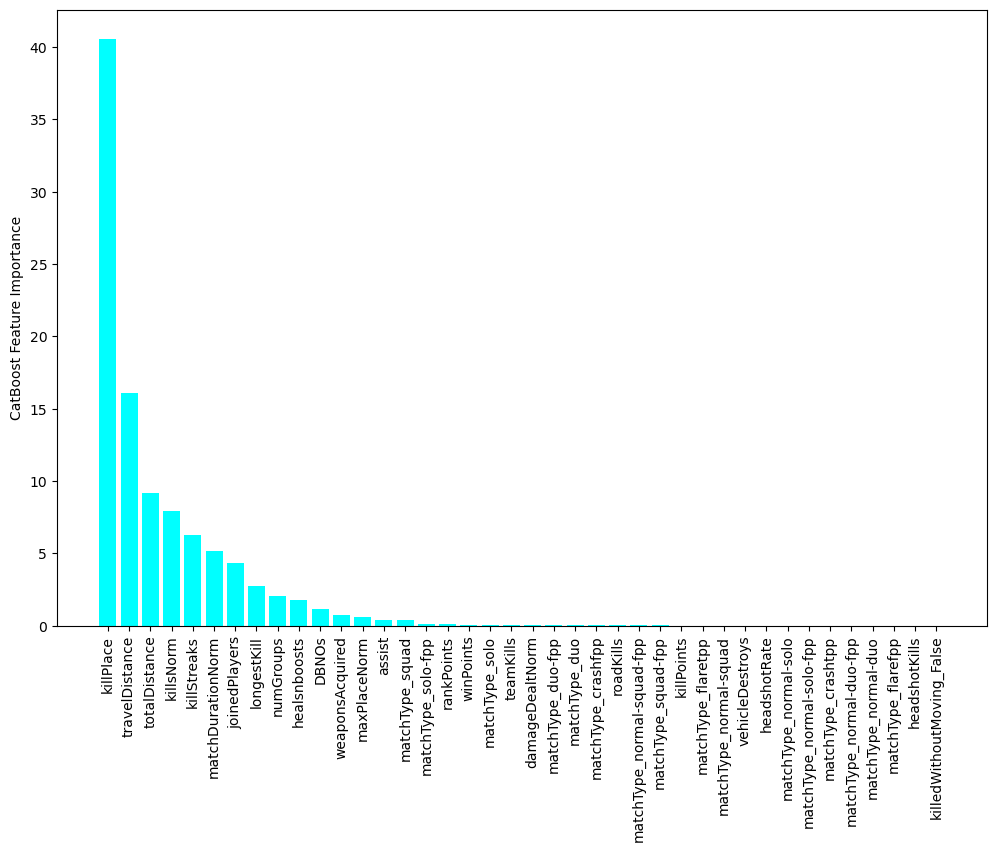

In [119]:
plt.bar(feature_importance_df.Features, feature_importance_df.Importance, color = 'cyan')
plt.ylabel("CatBoost Feature Importance")
plt.xticks(rotation = 90)
plt.show()

Prediction

In [120]:
y_pred = model.predict(x_test)

In [121]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print('Tetsing Performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Tetsing Performance
RMSE: 0.08
R2: 0.93
